In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn import metrics 
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.cluster import KMeans

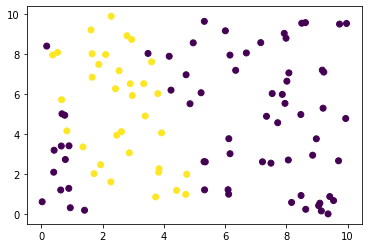

In [2]:
df = pd.read_csv('classification.csv')
x=df.values[:, 0:2]
y=df.values[:,2]
plt.scatter(x[:, 0], x[:, 1],c=y)
plt.show()

In [3]:
def getModel():
    #model = SGDClassifier(loss='log')
    model = LogisticRegression()
    return model

In [4]:
# utilities

# divide x, y into k list of same size
def getSplitData(x, y, k):
    arr = [i for i in range(len(x))]
    random.shuffle(arr)
    pList = np.array_split(np.array(arr), k)
    xlist, ylist = [], []
    for fold in pList:
        xlist.append(x[fold])
        ylist.append(y[fold])
    return xlist, ylist

# randomly draw n samples from x, y
def drawSample(x, y, n):
    arr = [i for i in range(len(x))]
    random.shuffle(arr)
    p1, p2 = arr[:n], arr[n:]
    return x[p1], x[p2], y[p1], y[p2]

# return 5-fold CV train accuracy
def crossValidation(x, y):
    #split data for cross-validation
    xlist, ylist = getSplitData(x, y, 5)
    trainAcc = []
    for i in range(5):
        model = getModel()
        xtest, ytest = xlist[i], ylist[i]
        xtrain = np.concatenate((xlist[:i] + xlist[i+1:]))
        ytrain = np.concatenate((ylist[:i] + ylist[i+1:]))
        model.fit(xtrain, ytrain)
        trainAcc.append(metrics.accuracy_score(ytest, model.predict(xtest)))
    model = getModel()
    model.fit(x, y)
    return model, np.mean(trainAcc)

In [5]:
#uncertainy sampling
def uncertainSample(model, xtest, ytest):
    predProb = model.predict_proba(xtest)
    predConf = [1-np.max(i) for i in predProb] # calculate confidence for new data
    p = np.argmax(predConf)
    return xtest[p], ytest[p], np.delete(xtest, p, 0), np.delete(ytest, p)

def uncertainTrain(x, y, init, end):
    xObs, xUnob, yObs, yUnob = drawSample(x, y, init)
    evaluation = []
    while len(xObs) <= end:
        model = getModel()
        model.fit(xObs, yObs)
        evaluation.append(model.score(xUnob, yUnob))
        # append new samples
        xNew, yNew, xUnob, yUnob = uncertainSample(model, xUnob, yUnob)
        xObs = np.concatenate((xObs, [xNew]))
        yObs = np.concatenate((yObs, [yNew]))
    return evaluation

In [6]:
def passiveTrain(x, y, init, end):
    #start with 20 samples at first
    xObs, xUnob, yObs, yUnob = drawSample(x, y, init) # observed and unobserved data
    evaluation = []
    while len(xObs) <= end:
        model = getModel()
        model.fit(xObs, yObs)
        evaluation.append(model.score(xUnob, yUnob))
        # append new samples
        xNew, xUnob, yNew, yUnob = drawSample(xUnob, yUnob, 1)
        xObs = np.concatenate((xObs, xNew))
        yObs = np.concatenate((yObs, yNew))
    return evaluation

In [7]:
def uncertainBatch(x, y, init, end, k):
    xObs, xUnob, yObs, yUnob = drawSample(x, y, init)
    evaluation = []
    while len(xObs) <= end:
        model = getModel()
        model.fit(xObs, yObs)
        evaluation.append(model.score(xUnob, yUnob))
        i=0
        while i < k:
            xNew, yNew, xUnob, yUnob = uncertainSample(model, xUnob, yUnob)
            xObs = np.concatenate((xObs, [xNew]))
            yObs = np.concatenate((yObs, [yNew]))
            i+=1
    return evaluation

In [8]:
# run simluation
passive, uncertain, batch = [], [], []
for i in range(10):
    random.seed(i)
    print("in simulation", i)
    passiveEva = passiveTrain(x, y, 5, 50)
    passive.append(passiveEva)
    random.seed(i)
    uncertainEva = uncertainTrain(x, y, 5, 50)
    uncertain.append(uncertainEva)
    random.seed(i)
    batch.append(uncertainBatch(x, y, 5, 50, 3))
    
# calculate mean and std for 10 simulation
uncertainMean = [np.mean(i) for i in np.transpose(np.array(uncertain))]
uncertainStd = [np.std(i) for i in np.transpose(np.array(uncertain))]

passiveMean = [np.mean(i) for i in np.transpose(np.array(passive))]
passiveStd = [np.std(i) for i in np.transpose(np.array(passive))]

batchMean = [np.mean(i) for i in np.transpose(np.array(batch))]
batchStd = [np.std(i) for i in np.transpose(np.array(batch))]

in simulation 0
in simulation 1
in simulation 2
in simulation 3
in simulation 4
in simulation 5
in simulation 6
in simulation 7
in simulation 8
in simulation 9


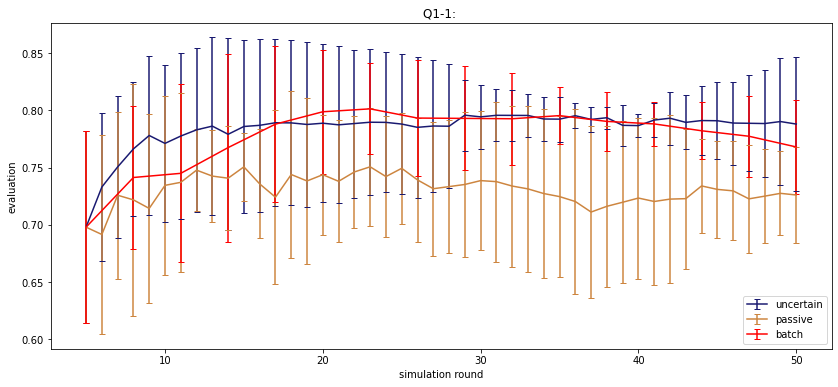

In [9]:
# plot the graph
xaxis = np.arange(len(uncertainMean))+5
batchx = [i*3+5 for i in range(len(batchMean))]
plt.rcParams["figure.figsize"] = (14,6)
plt.errorbar(xaxis, uncertainMean, yerr = uncertainStd,  label = 'uncertain', color = 'midnightblue', ecolor='midnightblue',capsize=3)
plt.errorbar(xaxis, passiveMean, yerr = passiveStd, label = 'passive', color = 'peru', ecolor='peru',capsize=3)
plt.errorbar(batchx, batchMean, yerr = batchStd, label = 'batch', color = 'red', ecolor='red', capsize=3)

plt.xlabel("simulation round")
plt.ylabel("evaluation")
plt.title("Q1-1: ")
plt.legend()
plt.show()

In [10]:
def diversitySample(xUnob, yUnob, k):
    # cluster samples
    kmeans = KMeans(n_clusters=k, init='random', max_iter=300, tol=1e-04, random_state=0)
    cluster = kmeans.fit_predict(xUnob)
    xselect, yselect, xremain, yremain = [], [], [], []
    
    for c in range(k):
        # get points in cluster-c
        yc = []
        xc = xUnob[cluster==c]
        for i, _ in enumerate(xUnob):
            if cluster[i] == c:
                yc.append(yUnob[i])
        # random select
        pop = random.randint(0,len(xc)-1)
        xselect.append(xc[pop]), yselect.append(yc[pop])
        for xr in np.delete(xc, pop, 0):
            xremain.append(xr)
        for yr in np.delete(yc, pop):
            yremain.append(yr) 

    return xselect, np.array(xremain), yselect, np.array(yremain)

def diversityTrain(x, y, init, end, k):
    xObs, xUnob, yObs, yUnob = drawSample(x, y, init)
    evaluation = []
    while len(xObs) <= end:
        model = getModel()
        model.fit(xObs, yObs)
        evaluation.append(model.score(xUnob, yUnob))
        # append new samples
        xNew, xUnob, yNew, yUnob = diversitySample(xUnob, yUnob, k)
        xObs = np.concatenate((xObs, xNew))
        yObs = np.concatenate((yObs, yNew))
    return evaluation

In [11]:
#q1-b simulation
diversity = []
for i in range(10):
    random.seed(i)
    print("in simulation", i)
    diversity.append(diversityTrain(x, y, 5, 50, 3))

diversityMean = [np.mean(i) for i in np.transpose(np.array(diversity))]
diversityStd = [np.std(i) for i in np.transpose(np.array(diversity))]

in simulation 0
in simulation 1
in simulation 2
in simulation 3
in simulation 4
in simulation 5
in simulation 6
in simulation 7
in simulation 8
in simulation 9


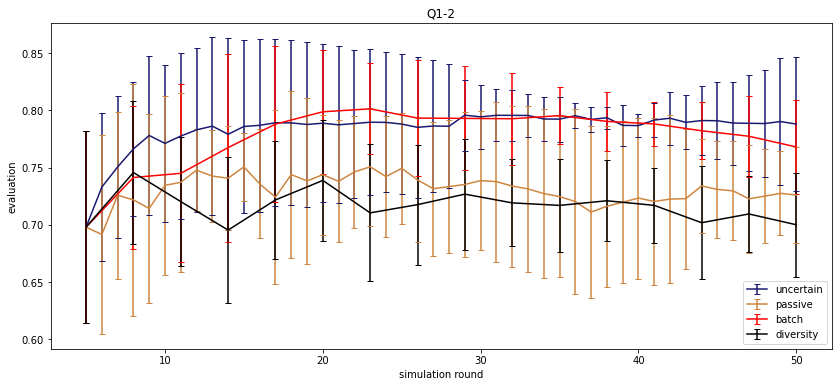

In [12]:
# plot the graph
xaxis = np.arange(len(uncertainMean))+5
batchx = [i*3+5 for i in range(len(batchMean))]
plt.rcParams["figure.figsize"] = (14,6)
plt.errorbar(xaxis, uncertainMean, yerr = uncertainStd,  label = 'uncertain', color = 'midnightblue', ecolor='midnightblue',capsize=3)
plt.errorbar(xaxis, passiveMean, yerr = passiveStd, label = 'passive', color = 'peru', ecolor='peru',capsize=3)
plt.errorbar(batchx, batchMean, yerr = batchStd, label = 'batch', color = 'red', ecolor='red', capsize=3)
plt.errorbar(batchx, diversityMean, yerr=diversityStd, label='diversity', color ='black', ecolor='black', capsize=3)

plt.xlabel("simulation round")
plt.ylabel("evaluation")
plt.title("Q1-2")
plt.legend()
plt.show()